# Twitter US Airline Sentiment

# ETL Pipeline Preparation

### 1. Import libraries and load datasets.
- Import Python libraries
- Load `Tweets.csv` into a dataframe and inspect the first few lines.

In [1]:
# import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
# load messages dataset
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data Exploration and Cleaning
The data will be briefly explored and necessary cleaning steps will be applied to the dataset.

In [3]:
# check data dimension
df.shape

(14640, 15)

- The dataset contains 14,640 rows and 15 columns

In [4]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- 8 features have no missing values including the columns of interest for this project (i.e. airline sentiment and text features). However, little cleaning will be done. It's also noteworthy that the airline_sentiment_gold and negativereason_gold features have large missing values. Hence they will be dropped since they add no value to the project.

In [5]:
# check the unique values in the airline_sentiment feature
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

- It's evident from the result that there are more negative sentiments than positive and neutral sentiments.

### Remove Duplicates

In [6]:
# check duplicates
df.duplicated().sum()

36

In [7]:
# drop duplicates
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

### Drop Irrelevant Data

In [9]:
# drop columns with mostly NaN values or irrelevant columns
df.drop(['tweet_id', 'airline_sentiment_gold', 'negativereason_gold'], axis=1, inplace=True)

### Handle Missing Values

In [10]:
# handle missing values
df['negativereason'] = df.apply(lambda row: 'Unknown' if row['airline_sentiment'] == 'negative' and pd.isna(row['negativereason']) else row['negativereason'], axis=1)
df['negativereason_confidence'].fillna(0, inplace=True) # Fill missing values with 0
df['tweet_location'].fillna('Unknown', inplace=True) # Fill misising values with Unknown

### Convert tweet created variable to datetime

In [11]:
# convert tweet_created to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

### Clean the text

In [12]:
# text cleaning (removing mentions, URLs etc.)
df['text'] = df['text'].str.replace(r'@\w+', '', regex=True).str.replace(r'http\S+', '', regex=True).str.strip()

### Encode the target variable

In [13]:
# manual encoding of the target variable 'airline_sentiment'
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

In [14]:
# check the updated dataframe
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,1,1.0000,NaN,0.0000,Virgin America,cairdin,0,What said.,NaN,2015-02-24 11:35:52-08:00,Unknown,Eastern Time (US & Canada)
1,2,0.3486,NaN,0.0000,Virgin America,jnardino,0,plus you've added commercials to the experienc...,NaN,2015-02-24 11:15:59-08:00,Unknown,Pacific Time (US & Canada)
2,1,0.6837,NaN,0.0000,Virgin America,yvonnalynn,0,I didn't today... Must mean I need to take ano...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,0,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,"it's really aggressive to blast obnoxious ""ent...",NaN,2015-02-24 11:15:36-08:00,Unknown,Pacific Time (US & Canada)
4,0,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,and it's a really big bad thing about it,NaN,2015-02-24 11:14:45-08:00,Unknown,Pacific Time (US & Canada)


### Data Visualisation

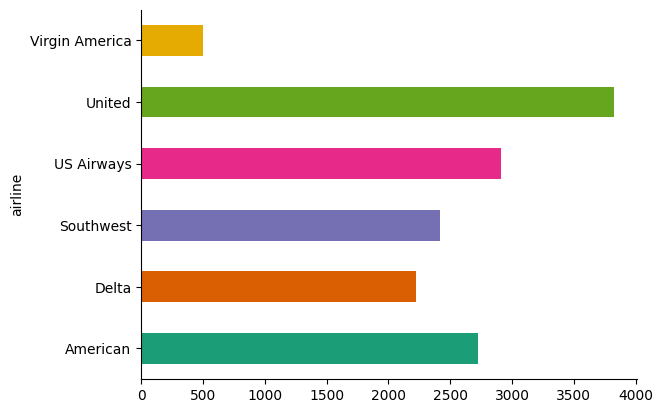

In [15]:
# plot airline distribution
df.groupby('airline').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

- United has the highest number of tweets followed by the US Airways. Virgin America has the lowest number of tweets.

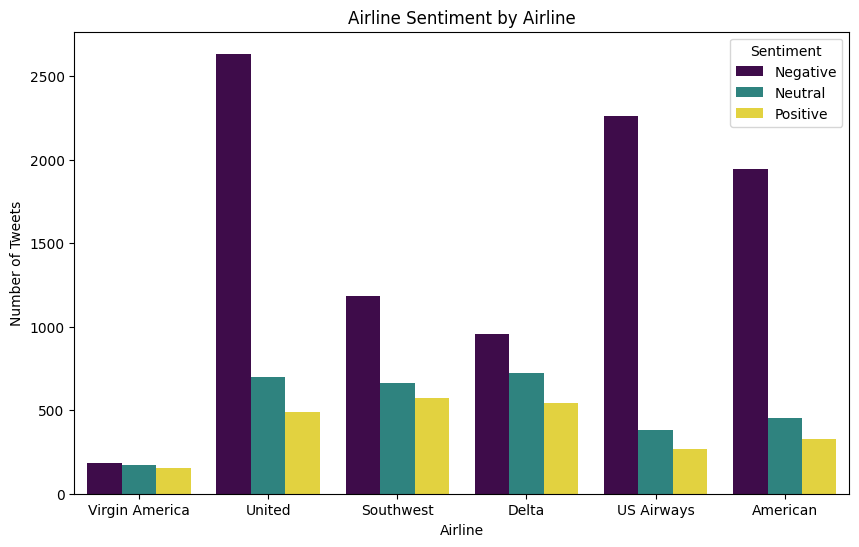

In [16]:
# plot the airline sentiment by airline
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='airline', hue='airline_sentiment', palette='viridis')
plt.title('Airline Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.show()

- Negative sentiments are dominant across board.

### Save the clean dataset into an sqlite database.
This will be done with pandas to_sql method combined with the SQLAlchemy library.

In [ ]:
engine = create_engine('sqlite:///AirlineSentiment.db')
df.to_sql('tweets', engine, index=False, if_exists='replace')